In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 23.6 MB/s eta 0:00:00


In [ ]:
!pip install -q condacolab
import condacolab


In [ ]:
import logging
import sys
from base64 import b64encode

import numpy as np

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, SDWriter, rdchem
from rdkit.Chem.Scaffolds import MurckoScaffold

InteractiveRenderer = None
drawOptions = None
if hasattr(rdkit, 'IPythonConsole'):
  try:
    from rdkit.Chem.Draw.IPythonConsole import InteractiveRenderer, drawOptions
  except ImportError:
    pass

from io import BytesIO
from xml.dom import minidom

In [ ]:
!pip install pubchempy

  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=9d54565d1b0fc0653c225c134c9c299d231664e744bc4131b43c58165af7c727
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [ ]:
import math
import pandas as pd
import numpy as np
import seaborn as sn
import pubchempy
#---------------------- RDKit packages
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
#------------------- progress bar
from tqdm import tqdm
#------------------- hide warning
import warnings
warnings.filterwarnings('ignore')

# Dataset

In [ ]:
dataset = pd.read_csv('https://raw.githubusercontent.com/gashawmg/HOMO-LUMO-Enegry-gap-Prediction/master/Orbital_Energies_input_data.csv')
dataset.head(10)

,SMILES,Energygap
0,Cc1ccc(cc1)C(F)(F)F,197.749421
1,OC(=O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,C[C@@H](CCO)CCC=C(C)C,209.569808
5,OC(C=C)C=C,210.979194
6,O=N(=O)c1ccc(Cl)c(c1)N(=O)=O,168.833179
7,O=CC1CCCCC1,213.451579
8,COc1ccc(cc1)C#C,171.191985
9,Brc1cncnc1,188.344944


In [ ]:
# Include 2D structure of molecules
#https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/PandasTools.py

from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(dataset,'SMILES', 'Structure')

In [ ]:
dataset.head()

,SMILES,Energygap,Structure
0,Cc1ccc(cc1)C(F)(F)F,197.749421,<rdkit.Chem.rdchem.Mol object at 0x7e68087bbf40>
1,OC(=O)CCCCl,247.493942,<rdkit.Chem.rdchem.Mol object at 0x7e68087bbe60>
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327,<rdkit.Chem.rdchem.Mol object at 0x7e6808698190>
3,Nc1ccc(Cl)c(Cl)c1,169.027707,<rdkit.Chem.rdchem.Mol object at 0x7e68086982e0>
4,C[C@@H](CCO)CCC=C(C)C,209.569808,<rdkit.Chem.rdchem.Mol object at 0x7e6808698350>


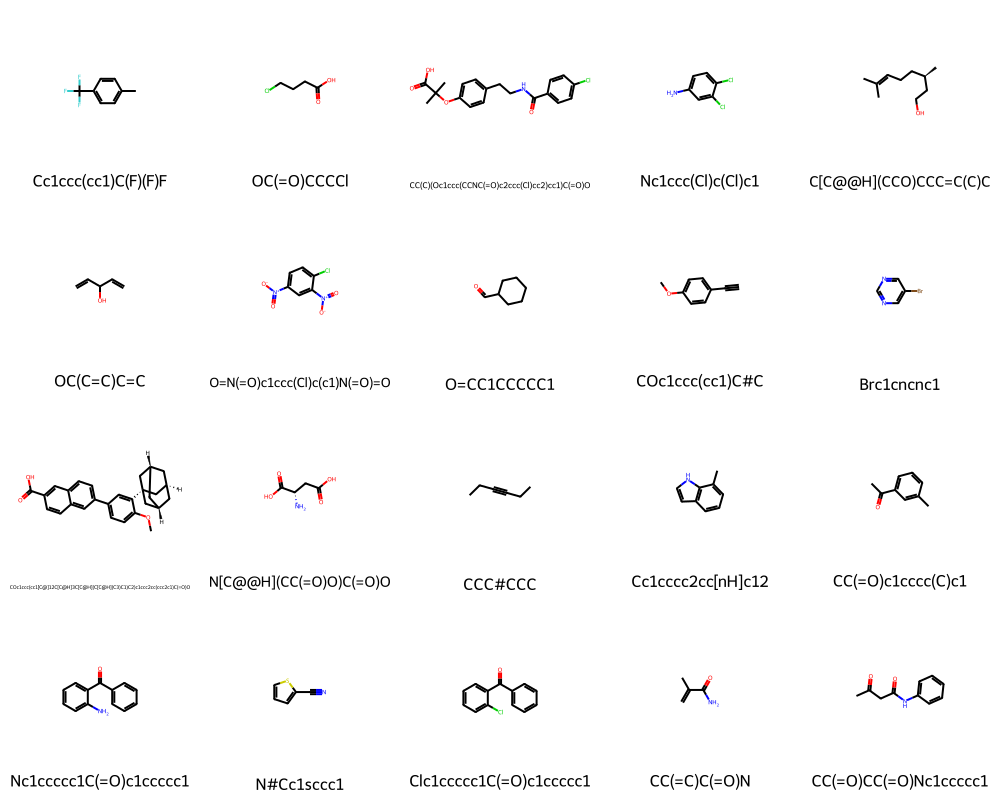

In [ ]:

Draw.MolsToGridImage([x for x in dataset["Structure"]][:20], maxMols=100,
                     legends=[str(x) for x in dataset.SMILES], subImgSize=(200,200), molsPerRow=5)

In [ ]:
dataset.shape

(2904, 3)

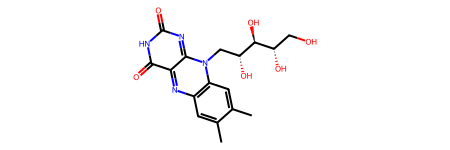

In [ ]:
dataset.Structure[1332]

# Morgan Fingerprint

In [ ]:
onbits = {}
morgan_fingerprint = AllChem.GetMorganFingerprintAsBitVect(dataset.Structure[2222], 2, nBits=512, bitInfo=onbits)
test_binary_vector = np.array(morgan_fingerprint)
print(test_binary_vector)

[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 

In [ ]:
# print On bits
print("Index of On bits:",tuple(morgan_fingerprint.GetOnBits()))
# how many bits are On?
print("Number of On bits: ",len(morgan_fingerprint.GetOnBits()))

Index of On bits: (1, 4, 21, 33, 36, 39, 55, 71, 84, 86, 104, 138, 158, 184, 201, 202, 212, 214, 223, 250, 268, 283, 295, 301, 317, 337, 339, 341, 348, 356, 360, 363, 381, 389, 394, 414, 444, 463, 469, 478, 492, 507)
Number of On bits:  42


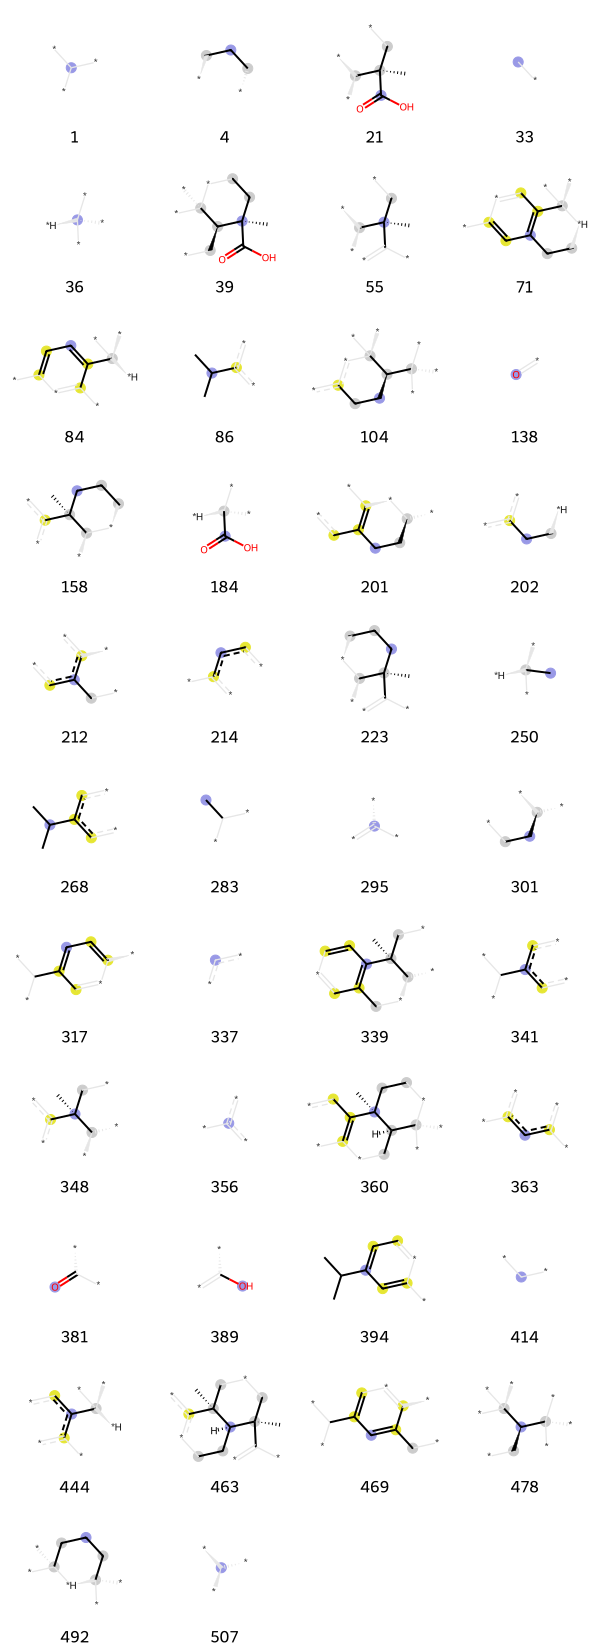

In [ ]:
# Render all the fragments or features that are responsible for making ON bits
all_fragments = [(dataset.Structure[2222], x, onbits) for x in morgan_fingerprint.GetOnBits()]
Draw.DrawMorganBits(all_fragments[:],molsPerRow=4, legends=[str(x) for x in morgan_fingerprint.GetOnBits()][:])

# RDkit Fingerprint

In [ ]:
rdkbi = {}
Rdk = AllChem.RDKFingerprint(dataset.Structure[0], maxPath=5, fpSize=512, bitInfo=rdkbi)
print(np.array(AllChem.RDKFingerprint(mol=dataset.Structure[0], maxPath=5, fpSize=512)))

[0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 1 0 

In [ ]:
# print On bits
print("Index of On bits:",tuple(Rdk.GetOnBits()))
# how many bits are On?
print("Number of On bits: ",len(Rdk.GetOnBits()))

Index of On bits: (2, 9, 16, 17, 19, 27, 28, 36, 40, 41, 62, 63, 93, 103, 124, 127, 137, 152, 157, 161, 170, 192, 194, 196, 205, 232, 248, 252, 271, 278, 280, 294, 309, 314, 324, 330, 342, 343, 353, 373, 383, 389, 405, 418, 432, 437, 441, 451, 460, 465, 470, 473, 481, 485, 491, 501)
Number of On bits:  56


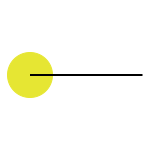

In [ ]:
# Visualize a fragment using index of ON bit
Draw.DrawRDKitBit(dataset.Structure[0],418,rdkbi)

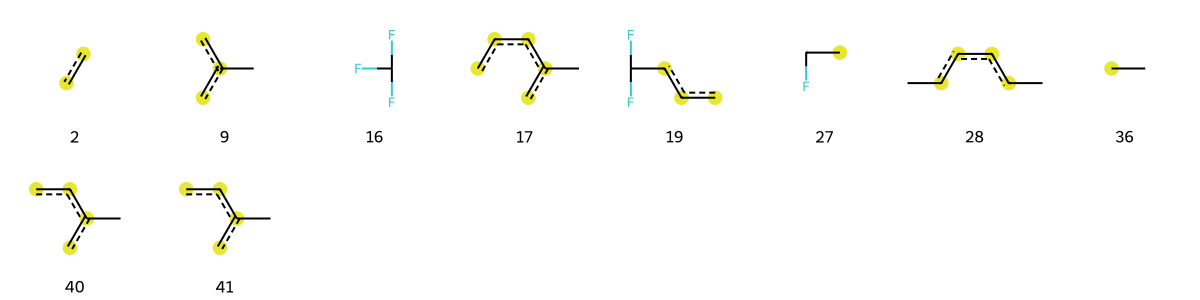

In [ ]:
# Visualize more fragments
fragments = [(dataset.Structure[0], x, rdkbi) for x in rdkbi]
Draw.DrawRDKitBits(fragments[:10],molsPerRow=8,legends=[str(x) for x in rdkbi][:10])

# Similarity Map

In [ ]:
mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
refmol = Chem.MolFromSmiles('CCCN(CCCCN1CCN(c2ccccc2OC)CC1)Cc1ccc2ccccc2c1')

In [ ]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps

fp = SimilarityMaps.GetMorganFingerprint(mol, fpType='bv')

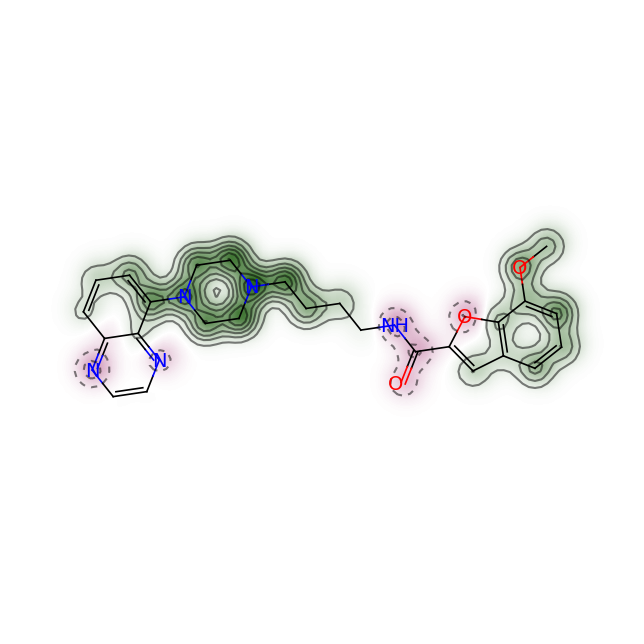

In [ ]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint)

# Hashing

All tables

In [ ]:
import hashlib
# Initialize parameters
num_tables = 293  # Number of hash tables
num_buckets = 40000  # Number of buckets per table
r = 7
table_seeds = np.random.randint(0, 30, num_tables, dtype=int)  # Different seed for each table


# Jaccard similarity hash function, compute_minhash_tuple, and hash_tuple_with_seed
def jaccard_hash_with_seed(test_binary_vector, seed):
    np.random.seed(seed)
    random_vector = np.random.uniform(0, 1, size=len(test_binary_vector))
    minhash = 1
    for i in range(len(test_binary_vector)):
        if test_binary_vector[i] == 1:
            hash_value = random_vector[i]
            minhash = min(minhash, hash_value)
    return minhash

def compute_minhash_tuple(test_binary_vector, num_hashes, seeds):
    return tuple(jaccard_hash_with_seed(test_binary_vector, seed) for seed in seeds)

# Hash tuple with seed function
def hash_tuple_with_seed(tuple_object, m, seed):
    tuple_string = str(tuple_object)
    hash_object = hashlib.sha256(str(seed).encode('utf-8'))
    hash_object.update(tuple_string.encode('utf-8'))
    hash_value = hash_object.hexdigest()
    hash_value_int = int(hash_value, 16)
    return hash_value_int % m + 1

# Initialize buckets for each table
smiles_buckets = {table: {} for table in range(num_tables)}
similarity_scores = []

# Process each SMILE
for idx, smile in enumerate(dataset['SMILES']):
    mol = Chem.MolFromSmiles(smile)
    fingerprint = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=512))

    # Hash to each table
    for table_idx in range(num_tables):
        np.random.seed(table_idx)
        minhash_tuple = compute_minhash_tuple(fingerprint, r, np.random.randint(0, 1000, r, dtype=int))
        bucket_idx = hash_tuple_with_seed(minhash_tuple, num_buckets, table_seeds[table_idx])
        if bucket_idx not in smiles_buckets[table_idx]:
            smiles_buckets[table_idx][bucket_idx] = []
        smiles_buckets[table_idx][bucket_idx].append(idx)


In [ ]:
def query_structure(query_smile):
    # Convert the query SMILE to a fingerprint
    query_mol = Chem.MolFromSmiles(query_smile)
    query_fingerprint = AllChem.GetMorganFingerprintAsBitVect(query_mol, radius=2, nBits=512)
    query_vec = np.array(query_fingerprint)
    #print(query_vec)


    similar_structures = set()

    # Find similar structures
    for table_idx in range(num_tables):
        np.random.seed(table_idx)
        query_minhash = compute_minhash_tuple(query_vec, r, np.random.randint(0, 1000, r, dtype=int))
        query_bucket_idx = hash_tuple_with_seed(query_minhash, num_buckets, table_seeds[table_idx])
        similar_structures.update(smiles_buckets[table_idx][query_bucket_idx])

    return similar_structures



# Which structures are similar to given structure:
query_smile = "Oc1cccc(C=O)c1"  # Replace with my query SMILE
similar_indices = query_structure(query_smile)
print(f"Indices of similar structures: {similar_indices}")

Indices of similar structures: {2433, 642, 899, 1924, 4, 1800, 1420, 1425, 401, 2580, 1559, 2073, 2329, 670, 2590, 33, 2849, 1572, 1446, 2092, 1456, 2097, 176, 1073, 2613, 1206, 1466, 1595, 701, 1213, 1857, 70, 2887, 2634, 1995, 2506, 974, 2645, 982, 859, 94, 2654, 991, 355, 2787, 1765, 365, 114, 2293, 2423, 1022, 2687}


In [ ]:
dataset.SMILES[33]

'Oc1cccc(C=O)c1'

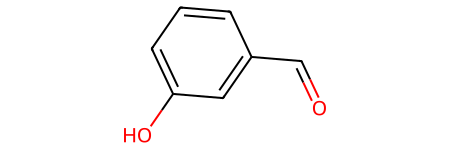

In [ ]:
dataset.Structure[33]


# Jaccard Similarity




Jaccard similarity with structure at index 2433: 0.5172413793103449
Jaccard similarity with structure at index 899: 0.5555555555555556
Jaccard similarity with structure at index 2580: 0.5384615384615384
Jaccard similarity with structure at index 2073: 0.5925925925925926
Jaccard similarity with structure at index 33: 1.0
Jaccard similarity with structure at index 2092: 0.42857142857142855
Jaccard similarity with structure at index 1206: 0.5
Jaccard similarity with structure at index 701: 0.4482758620689655
Jaccard similarity with structure at index 70: 0.4666666666666667
Jaccard similarity with structure at index 1995: 0.4090909090909091
Jaccard similarity with structure at index 2506: 0.5384615384615384
Jaccard similarity with structure at index 2654: 0.4782608695652174
Jaccard similarity with structure at index 355: 0.4827586206896552
Jaccard similarity with structure at index 1765: 0.5384615384615384
Jaccard similarity with structure at index 114: 0.5238095238095238


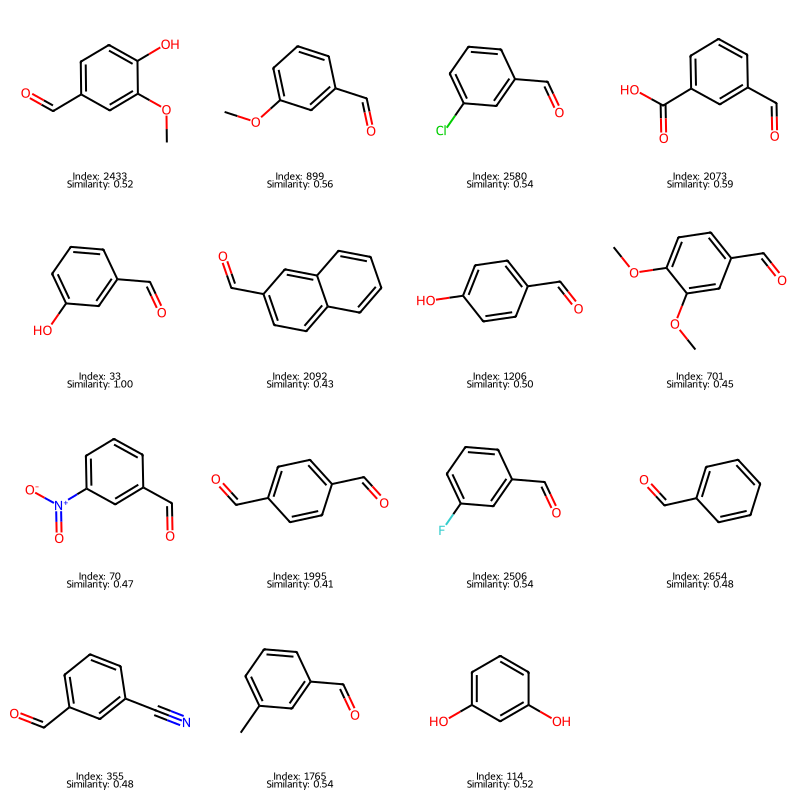

In [ ]:
def compute_jaccard_similarity(fp1, fp2):
    intersection = np.bitwise_and(fp1, fp2).sum()
    union = np.bitwise_or(fp1, fp2).sum()
    return intersection / union if union != 0 else 0

# Assuming query_smile and similar_indices are already defined
query_mol = Chem.MolFromSmiles(query_smile)
query_fingerprint = AllChem.GetMorganFingerprintAsBitVect(query_mol, radius=2, nBits=512)

jaccard_similarities = {}
similar_molecules = []  # List to store similar molecules
similar_legends = []
for idx in similar_indices:
    similar_smile = dataset['SMILES'][idx]
    similar_mol = dataset['Structure'][idx]  # Access the molecule using Structure column
    similar_fingerprint = AllChem.GetMorganFingerprintAsBitVect(similar_mol, radius=2, nBits=512)
    similarity = compute_jaccard_similarity(query_fingerprint, similar_fingerprint)
    jaccard_similarities[idx] = similarity

    # If similarity is above threshold, add molecule and legend for grid image
    if similarity > 0.4:
        print(f"Jaccard similarity with structure at index {idx}: {similarity}")
        similar_molecules.append(similar_mol)
        similar_legends.append(f"Index: {idx}\nSimilarity: {similarity:.2f}")

# Draw grid image of similar molecules
Draw.MolsToGridImage(similar_molecules, molsPerRow=4, legends=similar_legends)


In [ ]:
# Get the chemical name of the compound
smiles = 'Cc1ccc(cc1)C(F)(F)F'
compounds = pubchempy.get_compounds(smiles, namespace='smiles')
match = compounds[0]
print(match.iupac_name)

1-methyl-4-(trifluoromethyl)benzene


Optimization

In [ ]:
def choose_r_t():
  for r in range(1, 10000000):
    t = math.floor(math.log(.1)/math.log(1 - (0.5)**(r)))
    if 1 - (1 - (.3)**r)**t <= .1:
        print(r, t)
        break

choose_r_t()


7 293


In [ ]:
# Initialize an empty dictionary
smiles_fingerprints = {}

# Iterate through the SMILES column
for idx, smile in enumerate(dataset['SMILES']):
    # Convert the SMILE to an RDKit molecule object
    mol = Chem.MolFromSmiles(smile)

    # Generate the binary Morgan fingerprint
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)

    # Convert the fingerprint to a list of integers (0 or 1)
    fingerprint_list = list(fingerprint)

    # Add the SMILE and its fingerprint to the dictionary
    smiles_fingerprints[idx] = fingerprint_list

In [ ]:
# Compute the top 10 highest Jaccard similarities to the query vector

from heapq import nlargest

query_smile = "Cc1ccc(cc1)C(F)(F)F"
query_mol = Chem.MolFromSmiles(query_smile)
query_fp = AllChem.GetMorganFingerprintAsBitVect(query_mol, radius=2, nBits=1024)
query_vec = np.array(query_fp)

def jaccard_similarity(fp1, fp2):
    intersection = np.bitwise_and(fp1, fp2).sum()
    union = np.bitwise_or(fp1, fp2).sum()
    return intersection / union if union != 0 else 0

similarity_scores = []
for key, val in enumerate(smiles_fingerprints):
    similarity = jaccard_similarity(query_fp, smiles_fingerprints[val])
    similarity_scores.append((similarity, key))

# Find the top 10 highest similarity scores and their indices
top_10_similarities = nlargest(20, similarity_scores)

top_10_similarities

[(1.0, 0),
 (0.5238095238095238, 2630),
 (0.5238095238095238, 2000),
 (0.5238095238095238, 920),
 (0.5238095238095238, 520),
 (0.5238095238095238, 323),
 (0.5, 1493),
 (0.48, 1380),
 (0.47619047619047616, 40),
 (0.4583333333333333, 933),
 (0.4583333333333333, 577),
 (0.4583333333333333, 278),
 (0.45, 1253),
 (0.4444444444444444, 630),
 (0.4230769230769231, 1487),
 (0.4230769230769231, 1272),
 (0.4230769230769231, 1175),
 (0.4074074074074074, 2295),
 (0.38095238095238093, 2405),
 (0.38095238095238093, 1963)]

# Plot

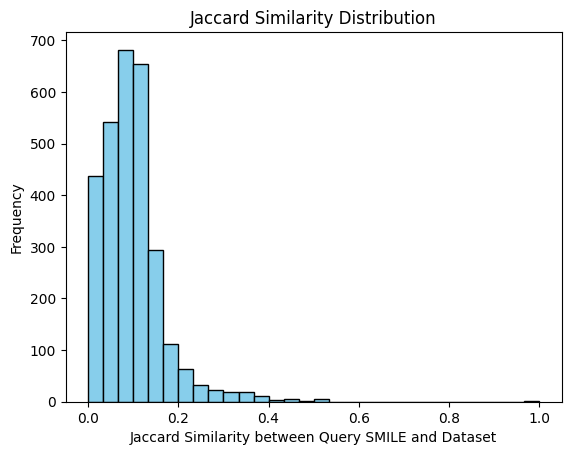

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random data for the histogram
data_hist = []
for sim, mol_idx in similarity_scores:
  data_hist.append(sim)

# Plotting a basic histogram
plt.hist(data_hist, bins=30, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Jaccard Similarity between Query SMILE and Dataset')
plt.ylabel('Frequency')
plt.title('Jaccard Similarity Distribution')

# Display the plot
plt.show()

Not using code below








# Previous Attempt

In [ ]:
#for molecule in similar_indices:
# Render all the fragments or features that are responsible for making ON bits
#    Draw.MolsToGridImage([x for x in dataset.Structure[molecule]], maxMols=100,
 #           legends=[str(x) for x in dataset.SMILES], subImgSize=(200,200), molsPerRow=5)
    #dataset.Structure[molecule]
    #all_similar = [(dataset.Structure[0], x, onbits) for x in morgan_fingerprint.GetOnBits()]
    #Draw.DrawMorganBits(all_fragments[:],molsPerRow=4, legends=[str(x) for x in morgan_fingerprint.GetOnBits()][:])

In [ ]:
def query_structure_with_fingerprints(query_smile):
    query_mol = Chem.MolFromSmiles(query_smile)
    query_fingerprint = AllChem.GetMorganFingerprintAsBitVect(query_mol, radius=2, nBits=1024)
    query_minhash = compute_minhash_tuple(query_fingerprint, len(minhash_seeds), minhash_seeds)

    similar_structures_fingerprints = []

    for table_idx in range(num_tables):
        query_bucket_idx = hash_tuple_with_seed(query_minhash, num_buckets, table_seeds[table_idx])
        similar_indices = smiles_buckets[table_idx].get(query_bucket_idx, [])

        for idx in similar_indices:
            similar_smile = dataset['SMILES'][idx]
            similar_mol = Chem.MolFromSmiles(similar_smile)
            similar_fingerprint = AllChem.GetMorganFingerprintAsBitVect(similar_mol, radius=2, nBits=1024)
            similar_structures_fingerprints.append(similar_fingerprint)

    return query_fingerprint, similar_structures_fingerprints

def compute_jaccard_similarity(fp1, fp2):
    intersection = np.bitwise_and(fp1, fp2).sum()
    union = np.bitwise_or(fp1, fp2).sum()
    return intersection / union if union != 0 else 0

# Example usage
query_smile = "Cc1ccc(cc1)C(F)(F)F"  # Replace with your query SMILE
query_fp, similar_fps = query_structure_with_fingerprints(query_smile)

similarities = [compute_jaccard_similarity(query_fp, fp) for fp in similar_fps]
print(f"Jaccard similarities: {similarities}")

NameError: name 'minhash_seeds' is not defined

In [ ]:
import hashlib

#minhash_seeds = [23, 10, 3, 17, 89, 105, 300, 212, 50, 174, 42, 333, 123, 60, 1, 500, 45, 403, 376, 520]  # Example seeds
minhash_seeds = np.random.randint(0, 1000, 25, dtype=int)
#bucket_seed = 17
num_buckets = 2873


# Jaccard similarity hash function
def jaccard_hash_with_seed(morgan_fingerprint, seed):
    np.random.seed(seed)
    random_vector = np.random.uniform(0, 1, size=len(morgan_fingerprint))
    minhash = 1
    for i in range(len(morgan_fingerprint)):
        if morgan_fingerprint[i] == 1:
            hash_value = random_vector[i]
            minhash = min(minhash, hash_value)
    return minhash


def compute_minhash_tuple(morgan_fingerprint, num_hashes, seeds):
    return tuple(jaccard_hash_with_seed(morgan_fingerprint, seed) for seed in seeds)


# Hash tuple with seed function
def hash_tuple_with_seed(tuple_object, m, seed):
    tuple_string = str(tuple_object)
    hash_object = hashlib.sha256(str(seed).encode('utf-8'))
    hash_object.update(tuple_string.encode('utf-8'))
    hash_value = hash_object.hexdigest()
    hash_value_int = int(hash_value, 16)
    return hash_value_int % m + 1

In [ ]:
print(minhash_seeds)

In [ ]:
jaccard_hash_with_seed(morgan_fingerprint,seed = 7)

In [ ]:
minhash_tuple = compute_minhash_tuple(morgan_fingerprint, len(minhash_seeds), minhash_seeds)
compute_minhash_tuple(morgan_fingerprint, len(minhash_seeds), minhash_seeds)

In [ ]:
hash_tuple_with_seed(minhash_tuple, num_buckets, minhash_seeds[0])

In [ ]:
smiles_buckets = {}


for smile in dataset['SMILES']:
    # Convert the SMILE to an RDKit molecule object
    mol = Chem.MolFromSmiles(smile)

    # Generate the binary Morgan fingerprint
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)

    minhash_tuple = compute_minhash_tuple(fingerprint, len(minhash_seeds), minhash_seeds)
    compute_minhash_tuple(fingerprint, len(minhash_seeds), minhash_seeds)
    smiles_buckets[smile] = hash_tuple_with_seed(minhash_tuple, num_buckets, minhash_seeds)

In [ ]:
count = 0

for key, value in smiles_buckets.items():
    print(f'{key}: {value}')
    count += 1
    if count >= 10:
        break

In [ ]:
from collections import defaultdict


# Invert the dictionary to group by buckets
buckets_smiles = defaultdict(list)
for smile, bucket in smiles_buckets.items():
    buckets_smiles[bucket].append(smile)


In [ ]:
count = 0

for key, value in buckets_smiles.items():
    print(f'{key}: {value}')
    count += 1
    if count >= 10:
        break

In [ ]:
for value in buckets_smiles:  # Loop through the first 10 buckets
    print(dataset.Structure[value]) #get the structure



In [ ]:
Draw.MolsToGridImage([value for value in buckets_smiles], maxMols=100,
                     legends=[str(value) for value in dataset.SMILES], subImgSize=(200,200), molsPerRow=8)

In [ ]:
def estimate_jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def optimize_jaccard_parameters(threshold, max_collision_prob, max_t=100):
    """
    Optimize r and t for Jaccard similarity.

    :param threshold: The similarity threshold for considering two items as similar.
    :param max_collision_prob: Maximum acceptable collision probability.
    :param max_t: Maximum number of hash tables to consider.
    :return: Optimized values of r and t.
    """
    for t in range(1, max_t + 1):
        r = compute_r(t, threshold)
        collision_prob = estimate_collision_probability(t, r, threshold)

        if collision_prob <= max_collision_prob:
            return t, r

    return None, None

def compute_r(t, threshold):
    return int(math.ceil(-math.log(threshold) / math.log(2) / t))

def estimate_collision_probability(t, r, threshold):
    """
    Estimate the probability of collision (false positives).

    :param t: Number of hash tables.
    :param r: Number of rows in each hash table.
    :param threshold: The similarity threshold for considering two items as similar.
    :return: Estimated collision probability.
    """
    return (1 - (threshold ** r)) ** t

# Example usage
desired_threshold = 0.8  # Desired threshold for considering items as similar
max_collision_prob = 0.01  # Maximum acceptable collision probability

optimized_t, optimized_r = optimize_jaccard_parameters(desired_threshold, max_collision_prob)

if optimized_t is not None and optimized_r is not None:
    print(f"Optimized t (number of hash tables): {optimized_t}")
    print(f"Optimized r (number of rows in each hash table): {optimized_r}")
else:
    print("Could not find suitable parameters within the specified limits.")